# Execution Details

1. GPU - Telsa P100 with 16GB RAM
2. Images: 250
3. img size 640, batch size 16
4. No. of epochs: 300 
5. Trained with torchhub weight: yolov5s

# Section 1. Install and Import Dependencies

In [ ]:
#check env for local run
import sys
sys.executable

### Note: When running on Colab, make sure to set Hardware Accelarator to GPU

In [1]:
!nvidia-smi # for GPU specification

Mon Dec 20 15:30:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!nvcc --version #to check CUDA version

In [ ]:
!cat /etc/os-release

In [17]:
import torch

use_cuda = torch.cuda.is_available()
use_cuda

True

In [3]:
if use_cuda:
    print('GPU found, proceeding with CUDA installation...')
    !pip install torch==1.8.2+cu111 torchvision==0.9.2+cu111 torchaudio==0.8.2 -f https://download.pytorch.org/whl/lts/1.8/torch_lts.html
else:
    print('GPU is not found, proceeding with CPU version installation...')
    !pip install torch==1.8.2+cpu torchvision==0.9.2+cpu torchaudio===0.8.2 -f https://download.pytorch.org/whl/lts/1.8/torch_lts.html

GPU found, proceeding with CUDA installation...
Looking in links: https://download.pytorch.org/whl/lts/1.8/torch_lts.html
     |█████████████▌                  | 834.1 MB 44.0 MB/s eta 0:00:27tcmalloc: large alloc 1147494400 bytes == 0x55cc46e32000 @  0x7f2005a22615 0x55cc0cf0b4cc 0x55cc0cfeb47a 0x55cc0cf0e2ed 0x55cc0cfffe1d 0x55cc0cf81e99 0x55cc0cf7c9ee 0x55cc0cf0fbda 0x55cc0cf81d00 0x55cc0cf7c9ee 0x55cc0cf0fbda 0x55cc0cf7e737 0x55cc0d000c66 0x55cc0cf7ddaf 0x55cc0d000c66 0x55cc0cf7ddaf 0x55cc0d000c66 0x55cc0cf7ddaf 0x55cc0cf10039 0x55cc0cf53409 0x55cc0cf0ec52 0x55cc0cf81c25 0x55cc0cf7c9ee 0x55cc0cf0fbda 0x55cc0cf7e737 0x55cc0cf7c9ee 0x55cc0cf0fbda 0x55cc0cf7d915 0x55cc0cf0fafa 0x55cc0cf7dc0d 0x55cc0cf7c9ee
     |█████████████████               | 1055.7 MB 1.3 MB/s eta 0:11:59tcmalloc: large alloc 1434370048 bytes == 0x55cc8b488000 @  0x7f2005a22615 0x55cc0cf0b4cc 0x55cc0cfeb47a 0x55cc0cf0e2ed 0x55cc0cfffe1d 0x55cc0cf81e99 0x55cc0cf7c9ee 0x55cc0cf0fbda 0x55cc0cf81d00 0x55cc0cf7c9ee 0x5

In [1]:
import torch
from matplotlib import pyplot as plt
import numpy as np
import cv2
import os
from datetime import datetime
import shutil

### 1.1 clone ultralytics repo and install the requirements

In [2]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 10310, done.
remote: Total 10310 (delta 0), reused 0 (delta 0), pack-reused 10310
Receiving objects: 100% (10310/10310), 10.56 MiB | 25.63 MiB/s, done.
Resolving deltas: 100% (7120/7120), done.


In [3]:
!cd yolov5 && pip install -r requirements.txt

     |████████████████████████████████| 596 kB 5.1 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


### 1.2 Define various paths

In [4]:
paths = {
    'DATA_PATH'  : os.path.join('data'),
    'IMAGES_PATH': os.path.join('data', 'images'),
    'LABELS_PATH': os.path.join('data', 'labels'),
    'VIDEOS_PATH': os.path.join('data', 'videos'),
    'INFER_PATH' : os.path.join('data', 'inference')
}

# Section 2. Data Preparation (Local run only)

In [ ]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
            
        if os.name == 'nt':
            !mkdir {path}

### 2.1 Rename images in serial order for easy reference. It will be like image001.jpg, image002.png etc..,

In [ ]:
cname = "image"  # This is the common name part of the file name
file_index = 207   # if 0, files will be renamed img001.jpg etc.., if 100, files will be renamed img100.jpg etc..,

for rootdir, subdir, files in os.walk(paths['IMAGES_PATH']):
    for file in files:
        fname, fext = file.split('.')        
        old_file = os.path.join(paths['IMAGES_PATH'], file)
        new_file = os.path.join(paths['IMAGES_PATH'], cname + f"{file_index:03}" + "." + fext.strip())
        os.rename(old_file, new_file)
        file_index += 1
        
print('Files renamed as per "{}..." pattern.'.format(cname))
        

### 2.2 Use labelimg to do annotations in YOLO format and save in data/images, data/labels (train, validation, test as applicable)

In [ ]:
paths.update ({
    'IMAGES_TRAIN': os.path.join('data', 'images', 'train'),
    'IMAGES_VAL': os.path.join('data', 'images', 'validation'),
    'LABELS_TRAIN': os.path.join('data', 'labels', 'train'),
    'LABELS_VAL': os.path.join('data', 'labels', 'validation'),
})

In [ ]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
            
        if os.name == 'nt':
            !mkdir {path}

#### 2.3 Manually move files from images folder to images/train, images/validation so that folder contains a fair representation of all classes including background images. Then run the below script to move the corresponding label files to labels/train, labels/validation

In [ ]:
paths

In [ ]:
from os import listdir
from os.path import isfile, join

num_train = num_val = num_train_bg = num_val_bg = 0

train_files = [f for f in listdir(paths['IMAGES_TRAIN']) if isfile(join(paths['IMAGES_TRAIN'], f))]
val_files = [f for f in listdir(paths['IMAGES_VAL']) if isfile(join(paths['IMAGES_VAL'], f))]

for file in train_files:
    fname, fext = file.split('.')
    try:
        num_train += 1
        shutil.move(os.path.join(paths['LABELS_PATH'], fname + ".txt"), paths['LABELS_TRAIN'])         
    except Exception as e:
        num_train_bg += 1
        
for file in val_files:
    fname, fext = file.split('.')
    try:
        num_val += 1
        shutil.move(os.path.join(paths['LABELS_PATH'], fname + ".txt"), paths['LABELS_VAL'])         
    except Exception as e:
        num_val_bg += 1        
        
        
print('Train images: {}; Validation images: {}; Train Background images: {}; Validation Background images: {}'
                                  .format(num_train, num_val, num_train_bg, num_val_bg))
    

### 2.4 On Colab, use one of the below options to get the data.
### 2.4.1 zip the local data folder, manually upload to colab and unzip using the below command

In [ ]:
# command to zip the local data folder
!tar -czf {'data_archive.tar.gz'} {paths['DATA_PATH']}
print('Archiving data file is now complete.')

In [ ]:
# command to unzip the folder from google colab
!tar -zxvf {'data_archive.tar.gz'}

### 2.4.2 Keep the data folder contents to your google drive and run the below command to copy to colab workspace

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# change location as per your GD structure
!cp -r 'drive/MyDrive/Colab Notebooks/Git Projects Data/Wildlife Inference/data' .

### 2.5 Run the below commands to verify the number of images in each of the folders (local vs colab) are same

In [7]:
!ls data/labels

classes.txt  train  validation


In [9]:
!ls data/images/train | wc -l
!ls data/images/validation | wc -l

214
33


In [10]:
!ls data/labels/train | wc -l 
!ls data/labels/validation | wc -l

195
30


# Section 3. Load Out of box Model from torch hub

In [ ]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s') # or yolov5m, yolov5l, yolov5x, custom

In [ ]:
model

## 3.1 Image Detection with Out of box model

In [ ]:
img = 'https://images.news18.com/ibnlive/uploads/2021/10/animal-day-16332888954x3.jpg'

In [ ]:
# img = 'https://ultralytics.com/images/zidane.jpg'

In [ ]:
results = model(img)
results.print()

In [ ]:
%matplotlib inline 
plt.rcParams["figure.figsize"] = (20,8)
plt.imshow(np.squeeze(results.render()))
plt.savefig(os.path.join(paths['INFER_PATH'], 'img_001' + '.png'))
plt.show()

In [ ]:
results.render()

# Section 4. Prepare custom images (For webcam use only)

In [ ]:
import uuid   # Unique identifier
import os
import time

In [ ]:
IMAGES_PATH = os.path.join('data', 'images') #/data/images
labels = ['awake', 'drowsy']
number_imgs = 5

In [ ]:
cap = cv2.VideoCapture(0)
# Loop through labels
for label in labels:
    print('Collecting images for {}'.format(label))
    time.sleep(5)
    
    # Loop through image range
    for img_num in range(number_imgs):
        print('Collecting images for {}, image number {}'.format(label, img_num))
        
        # Webcam feed
        ret, frame = cap.read()
        
        # Naming out image path
        imgname = os.path.join(IMAGES_PATH, label+'.'+str(uuid.uuid1())+'.jpg')
        
        # Writes out image to file 
        cv2.imwrite(imgname, frame)
        
        # Render to the screen
        cv2.imshow('Image Collection', frame)
        
        # 2 second delay between captures
        time.sleep(2)
        
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
cap.release()
cv2.destroyAllWindows()

In [ ]:
print(os.path.join(IMAGES_PATH, labels[0]+'.'+str(uuid.uuid1())+'.jpg'))

In [ ]:
for label in labels:
    print('Collecting images for {}'.format(label))
    for img_num in range(number_imgs):
        print('Collecting images for {}, image number {}'.format(label, img_num))
        imgname = os.path.join(IMAGES_PATH, label+'.'+str(uuid.uuid1())+'.jpg')
        print(imgname)   

In [ ]:
!git clone https://github.com/tzutalin/labelImg

In [ ]:
!pip install pyqt5 lxml --upgrade
!cd labelImg && pyrcc5 -o libs/resources.py resources.qrc

# Section 5. Custom Training (after images, labels folders are updated)

### 5.1 Keep the .yaml file in GD as per the dataset and run the below command to copy it to yolov5 folder

In [11]:
!cp 'drive/MyDrive/Colab Notebooks/Git Projects Data/Wildlife Inference/wildlife.yaml' 'yolov5'

### 5.2 If using past weights, keep it in GD and run the below command to copy them to yolov5 folder

In [ ]:
!cp -r 'drive/MyDrive/Colab Notebooks/Git Projects Data/Wildlife Inference/weights' 'yolov5'

### 5.3 Run the below cell to start the training process (change --weights param as needed)

In [13]:
!cd yolov5 && python train.py --img 640 --batch 16 --epochs 300 --data wildlife.yaml --weights yolov5s.pt --workers 2

train: weights=yolov5s.pt, cfg=, data=wildlife.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=300, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=2, project=runs/train, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.0-152-g26f0415 torch 1.8.2+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0.1, sc

### 5.4 zip the weights file on Colab space to manually export it to local machine

In [14]:
# zip experminet folder and manually export to local machine
!tar -czf exp_small.tar.gz {'yolov5/runs/train/exp2'}

In [15]:
!ls -lh

total 32M
drwx------ 6 root root 4.0K Dec 20 15:38 data
drwx------ 5 root root 4.0K Dec 20 15:38 drive
-rw-r--r-- 1 root root  32M Dec 20 18:25 exp_small.tar.gz
drwxr-xr-x 1 root root 4.0K Dec  3 14:33 sample_data
drwxr-xr-x 9 root root 4.0K Dec 20 15:41 yolov5


# Section 6. Custom Model Inference

## 6.1 Load Custom model

In [18]:
if use_cuda:
    model = torch.hub.load('ultralytics/yolov5', 'custom', path='yolov5/runs/train/exp2/weights/best.pt', force_reload=True)
else:
    model = torch.hub.load('ultralytics/yolov5', 'custom', path='exp/weights/best.pt', force_reload=True)

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /root/.cache/torch/hub/master.zip


requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...


YOLOv5 🚀 2021-12-20 torch 1.8.2+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)




requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



Fusing layers... 
Model Summary: 213 layers, 7045186 parameters, 0 gradients, 15.9 GFLOPs
Adding AutoShape... 


## 6.2 Image inference

In [19]:
img = 'https://images.news18.com/ibnlive/uploads/2021/10/animal-day-16332888954x3.jpg'

In [20]:
results = model(img)
results.print()

image 1/1: 1200x1600 4 Elephants, 1 Giraffe, 2 Lions, 1 Leopard
Speed: 2133.8ms pre-process, 18.6ms inference, 2.6ms NMS per image at shape (1, 3, 480, 640)


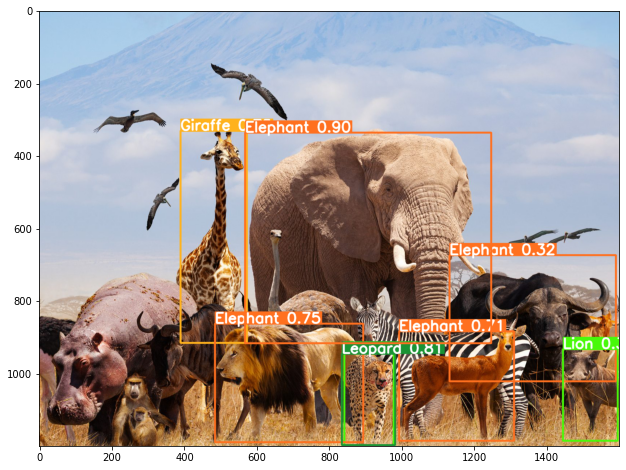

In [21]:
%matplotlib inline 
plt.rcParams["figure.figsize"] = (20,8)
plt.imshow(np.squeeze(results.render()))
plt.savefig(os.path.join(paths['INFER_PATH'], 'img_001' + '.png'))
plt.show()

## 6.3 Recorded Video Inference

In [ ]:
video_name = 'Wildlife-002.mp4' 
video_input = os.path.join(paths['VIDEOS_PATH'], video_name)

import tkinter as tk

root = tk.Tk()

screen_width = root.winfo_screenwidth()
screen_height = root.winfo_screenheight()

screen_width, screen_height

In [ ]:
from datetime import datetime
import time

start_time = datetime.now()

print('Inference started at: {}'.format(start_time.strftime("%I:%M:%S %p")))

cap = cv2.VideoCapture(video_input) # 0 for webcam
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
fps = cap.get(cv2.CAP_PROP_FPS)  # 15.0, set the video fps
out = cv2.VideoWriter(os.path.join(paths['INFER_PATH'], video_name), fourcc, fps, (screen_width, screen_height))
time.sleep(0.5) #delay to allow camera to load the feed

while cap.isOpened():
    ret, frame = cap.read()
    
    if not ret:
        break    
    
    #make detections
    results = model(frame)
    op = np.squeeze(results.render())
    out.write(cv2.resize(op, (screen_width, screen_height))) # (640, 480), (1280, 720), (screen_width, screen_height)    

    cv2.imshow('YOLOv5 Inference - Recorded video', op)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
        
cap.release()
out.release()
cv2.destroyAllWindows()

end_time = datetime.now()

print('Inference ended at: {}'.format(end_time.strftime("%I:%M:%S %p")))
print('Time taken for inference: {}'.format(end_time - start_time))                  
